In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from scipy.stats import pearsonr
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy.interpolate import interp1d

from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def simulate_CDDM(ub, lb, delta, loc, scale, ndt=0, z=0, sigma=1, dt=0.001):
    x = z
    
    rt = 0
    
    while lb(rt) < x and x < ub(rt):
        x += delta * dt + sigma*np.sqrt(dt)*np.random.normal(0, 1)
        rt += dt
        
    if x >= ub(rt):
        ch = 1
    else:
        ch = -1
        
    return (rt+ndt)*ch, np.random.lognormal(loc, scale)

In [3]:
def f(x, t, z, tau, delta, sigma=1):
    term1 = 1/np.sqrt(2 * np.pi * sigma**2 * (t-tau))
    term2 = -(x - z - delta * (t-tau))**2 / (2 * sigma**2 * (t-tau))
    return term1 * np.exp(term2)

def psi(b, db, t, z, tau, delta, sigma=1):
    term1 = 0.5*f(b(t), t, z, tau, delta, sigma)
    term2 = db(t) - delta - (b(t) - z - delta * (t-tau))/(t-tau)
    return term1 * term2

def fpt(ub, lb, dub, dlb, delta, z=0, sigma=1, dt=0.01, T_max=5):
    gu = [0]
    gl = [0]
    T = [0]
    
    gu.append(-2*psi(ub, dub, dt, z, 0, delta, sigma))
    gl.append( 2*psi(lb, dlb, dt, z, 0, delta, sigma))
    T.append(dt)
    
    for n in range(2, int(T_max/dt)+2):
        su = -2 * psi(ub, dub, n*dt, z, 0, delta, sigma)
        sl =  2 * psi(lb, dlb, n*dt, z, 0, delta, sigma)
        
        for j in range(1, n):
            if ub(j*dt) == 0:
                continue
            
            psi_n_j_pp = psi(ub, dub, n*dt, ub(j*dt), j*dt, delta, sigma)
            psi_n_j_pn = psi(ub, dub, n*dt, lb(j*dt), j*dt, delta, sigma)
            psi_n_j_np = psi(lb, dlb, n*dt, ub(j*dt), j*dt, delta, sigma)
            psi_n_j_nn = psi(lb, dlb, n*dt, lb(j*dt), j*dt, delta, sigma)
            
            su +=  2 * dt * (gu[j] * psi_n_j_pp + gl[j] * psi_n_j_pn)
            sl += -2 * dt * (gu[j] * psi_n_j_np + gl[j] * psi_n_j_nn)
            
        gu.append(su)
        gl.append(sl)
        T.append(n*dt)
        
    gu = np.asarray(gu)
    gl = np.asarray(gl)
    T = np.asarray(T)
    
    gtu = interp1d(T, gu)
    gtl = interp1d(T, gl)
    return gtu, gtl

In [4]:
def CDDM_likelihood(prms, RT, Z):
    ub = lambda t: prms[0] * np.exp(-prms[1]*t)
    lb = lambda t: -1*ub(t)
    dub = lambda t: -prms[1] * prms[0] * np.exp(-prms[1]*t)
    dlb = lambda t: -1*dub(t)

    delta = prms[2]
    sig = prms[3]
    t0 = prms[4]
    
    T_max = np.max(np.abs(RT))
    gtup, gtlp = fpt(ub, lb, dub, dlb, delta, z=0, dt=0.05, T_max=T_max)
#     gtun, gtln = fpt(ub, lb, dub, dlb, -delta, z=0, dt=0.05, T_max=T_max)
    
    ll = 0
    for i in range(len(RT)):
        if np.abs(RT[i])-t0 > 0:
            if RT[i]>=0:
                
                ll += 0.5*(np.log(Z[i]) - np.log(t0) + 0.5*sig**2)**2/sig**2 + 0.5*np.log(2*np.pi*sig**2*Z[i]**2)
                
                if gtup(RT[i])>1e-14:
                    ll += -np.log(gtup(np.abs(RT[i])-t0))
                else:
                    ll += -np.log(1e-14)
            else:
                
                ll += 0.5*(np.log(Z[i]) - np.log(t0) + 0.5*sig**2)**2/sig**2 + 0.5*np.log(2*np.pi*sig**2*Z[i]**2)
                
                if gtlp(np.abs(RT[i])-t0)>1e-14:
                    ll += -np.log(gtlp(np.abs(RT[i])-t0))
                else:
                    ll += -np.log(1e-14) 
        else:
            ll += -np.log(1e-14)
    
    return ll

In [5]:
recovery_dic = {'a_true': [],
                'a_estimate': [],
                'lambda_true': [],
                'lambda_estimate': [],
                'delta_true': [],
                'delta_estimate': [],
                'sigma_true':[],
                'sigma_estimate':[],
                'ndt_true':[],
                'ndt_estimate':[]}

In [6]:
for n in tqdm(range(25)):
    threshold = np.random.uniform(1.5, 4)
    lamda = np.random.uniform(0.1, 2)
    delta = np.random.uniform(0, 3)
    
    loc = np.random.uniform(-3, -0.5)
    scale = np.random.uniform(0.1, 1)
    ndt = np.exp(loc + 0.5*scale**2)
    
    ub = lambda t: threshold * np.exp(-lamda*t)
    lb = lambda t: -1*ub(t)
    
    RT = []
    Z = []
    
    for i in range(500):
        rt, z = simulate_CDDM(ub, lb, delta, loc, scale, ndt=ndt)
        RT.append(rt)
        Z.append(z)
        
    RT = np.array(RT)
    Z = np.array(Z)
    
    ans_cddm = differential_evolution(CDDM_likelihood,
                                      args=(RT, Z), 
                                      bounds=[(1.5, 4), (0.1, 2), (0, 3), 
                                              (0.1, 1), (0.05, 1)])
    ans_cddm = minimize(CDDM_likelihood,
                        args=(RT, Z),
                        method='Nelder-Mead',
                        x0=ans_cddm.x,
                        bounds=[(1.5, 4), (0.1, 2), (0, 3), 
                                (0.1, 1), (0.05, 1)])

    recovery_dic['a_true'].append(threshold)
    recovery_dic['a_estimate'].append(ans_cddm.x[0])
    recovery_dic['lambda_true'].append(lamda)
    recovery_dic['lambda_estimate'].append(ans_cddm.x[1])
    recovery_dic['delta_true'].append(delta)
    recovery_dic['delta_estimate'].append(ans_cddm.x[2])
    recovery_dic['sigma_true'].append(scale)
    recovery_dic['sigma_estimate'].append(ans_cddm.x[3])
    recovery_dic['ndt_true'].append(ndt)
    recovery_dic['ndt_estimate'].append(ans_cddm.x[4])

100%|████████████████████████████████████████| 25/25 [54:54<00:00, 131.78s/it]


In [7]:
recovery_df = pd.DataFrame(recovery_dic)

In [8]:
file_name = 'Exponential_rec.csv'
old_recovery_data = pd.read_csv(file_name, index_col=0)
recovery_df = pd.concat([old_recovery_data, 
                         recovery_df]).reset_index(drop=True)
recovery_df.to_csv(file_name)

In [9]:
print(recovery_df.shape[0])
recovery_df.corr()

75


,a_true,a_estimate,lambda_true,lambda_estimate,delta_true,delta_estimate,sigma_true,sigma_estimate,ndt_true,ndt_estimate
a_true,1.000000,0.970335,-0.045236,-0.051240,0.117333,0.121272,-0.150352,-0.139048,-0.028768,-0.030884
a_estimate,0.970335,1.000000,-0.029024,-0.001114,0.126161,0.116823,-0.145892,-0.139803,-0.041656,-0.054251
lambda_true,-0.045236,-0.029024,1.000000,0.973038,0.016331,0.010425,-0.226651,-0.219040,-0.067009,-0.060334
lambda_estimate,-0.051240,-0.001114,0.973038,1.000000,-0.031745,-0.068163,-0.203820,-0.198742,-0.049486,-0.046075
delta_true,0.117333,0.126161,0.016331,-0.031745,1.000000,0.986626,-0.044320,-0.029772,0.013570,0.014676
delta_estimate,0.121272,0.116823,0.010425,-0.068163,0.986626,1.000000,-0.062321,-0.048031,-0.009389,-0.007887
sigma_true,-0.150352,-0.145892,-0.226651,-0.203820,-0.044320,-0.062321,1.000000,0.997885,0.215882,0.211967
sigma_estimate,-0.139048,-0.139803,-0.219040,-0.198742,-0.029772,-0.048031,0.997885,1.000000,0.217656,0.215298
ndt_true,-0.028768,-0.041656,-0.067009,-0.049486,0.013570,-0.009389,0.215882,0.217656,1.000000,0.997686
ndt_estimate,-0.030884,-0.054251,-0.060334,-0.046075,0.014676,-0.007887,0.211967,0.215298,0.997686,1.000000


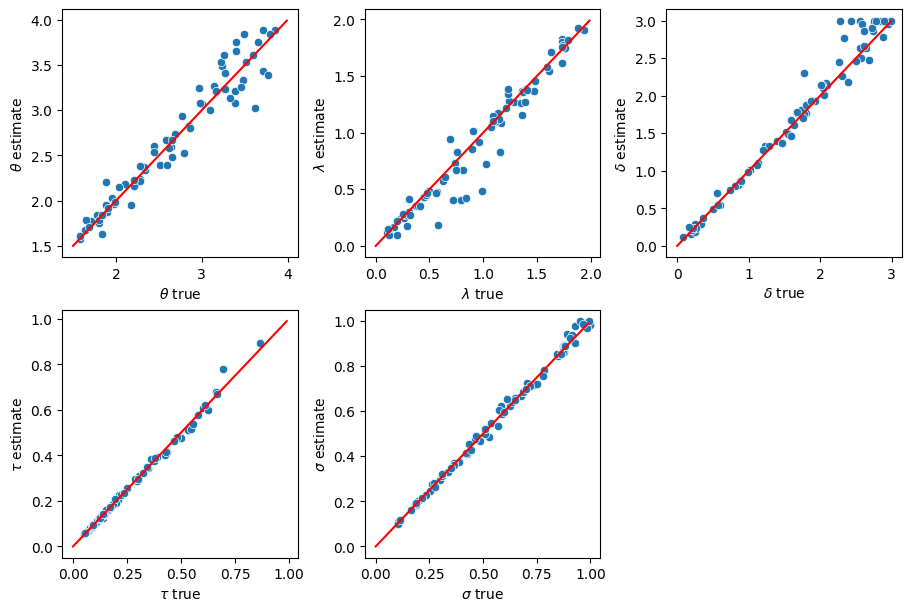

In [10]:
plt.figure(figsize=(9, 6), layout='constrained')

plt.subplot(231)
plt.plot(np.arange(1.5, 4, 0.01), np.arange(1.5, 4, 0.01), c='red')
sns.scatterplot(x='a_true', y='a_estimate', data=recovery_df);
plt.xlabel(r'$\theta$ true')
plt.ylabel(r'$\theta$ estimate')

plt.subplot(232)
plt.plot(np.arange(0, 2, 0.01), np.arange(0, 2, 0.01), c='red')
sns.scatterplot(x='lambda_true', y='lambda_estimate', data=recovery_df);
plt.xlabel(r'$\lambda$ true')
plt.ylabel(r'$\lambda$ estimate')

plt.subplot(233)
plt.plot(np.arange(0, 3, 0.01), np.arange(0, 3, 0.01), c='red')
sns.scatterplot(x='delta_true', y='delta_estimate', data=recovery_df);
plt.xlabel(r'$\delta$ true')
plt.ylabel(r'$\delta$ estimate')

plt.subplot(234)
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), c='red')
sns.scatterplot(x='ndt_true', y='ndt_estimate', data=recovery_df);
plt.xlabel(r'$\tau$ true')
plt.ylabel(r'$\tau$ estimate')

plt.subplot(235)
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), c='red')
sns.scatterplot(x='sigma_true', y='sigma_estimate', data=recovery_df);
plt.xlabel(r'$\sigma$ true')
plt.ylabel(r'$\sigma$ estimate');